# Machine Learning Exercise - reChAPTCHA

This small exercise implements a CNN which is trained to classify images taken from google's reCAPTCHA.
<div>
<img src=https://i.ds.at/LuvqbQ/rs:fill:1600:0/plain/2022/06/23/captcha.jpg width="300">
<div>

reCAPTCHA was created to differentiate between real humans and computer porgrams. With the breakthrough of deep learning based methods, these tactics to differentiate between humans and machines no longer work. Computer programs nowadays are perfectly able to solve classic captchas.

This notebook shows the initial steps to load the datasets, create a dummy classifier and use the classifier to create the resulting file, which you will upload for grading.

In [1]:
## Lots of imports
import matplotlib.pyplot as plt # for visualization
import numpy as np #for fast calculation of matrices and vectors
import os # for reading and writing files
import pandas as pd # for creating dataframes and later saving the .csv
import torch # PyTorch
import torch.nn as nn # layers of neural netowrk
from torch.utils.data import random_split, DataLoader # Creating datasets
import torchvision # the part of PyTorch which is used for images
from torchvision import datasets, models, transforms # used for loading images
from tqdm import tqdm # can be used to visualize progress of loops
import time # can be used to get current time
from sklearn.model_selection import StratifiedKFold
from torchvision.transforms import v2
import torchvision.models as models
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import RandomRotation, RandomApply, Pad
import torch.nn.functional as F



torch.cuda.empty_cache()



torch.manual_seed(3407) # makes your code deterministic so you can compare your results
np.random.seed(3407)

Download the two .zip files that are available on ilias.
You should have `train_val.zip` and `test.zip`





## Using Google Colab and Google Drive


* Upload both files (drag and drop) to your free google drive account https://drive.google.com/drive/my-drive
* On the left press the folder (Dateien) Symbol.
* Then press the *Mount drive/ Drive bereitstellen* button which has the google drive symbol (triangle)
* Allow access to your google drive


In [2]:
## If you did this correctly you should see here "drive" and "sample_data"
from google.colab import drive
drive.mount('/content/drive')
!ls


Mounted at /content/drive
drive  sample_data


Unzip the files in your Google Drive

In [ ]:
!unzip drive/MyDrive/Uni/Data/train_val.zip -d drive/MyDrive/Uni/Data
!unzip drive/MyDrive/Uni/Data/test.zip -d drive/MyDrive//Uni/Data


Archive:  drive/MyDrive/Uni/Data/train_val.zip
replace drive/MyDrive/Uni/Data/train_val_data/Bicycle/00387.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This should have created the folders train_val_data and test_data in your google drive.

In [3]:
root = "./drive/MyDrive/Uni/Data/"

Now we have to create Datasets from these folders.

For the train_val folder the images are sorted into their correct class folder.
For the test folder we don't know the correct classes.

We will use ImageFolder Datasets from  [PyTorch](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Each Image Folder uses [transforms](https://pytorch.org/vision/stable/transforms.html#v1-api-reference) to augment the image and create a tensor out of it. (Some example augmentations [here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py) )

Some initial transforms are given. You are allowed (and probably should) add more transformations or modify the existing ones

In [5]:
# Data Augmentation

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomApply([RandomRotation(degrees=(-40, 40))], p=0.5),
    Pad(padding=(10, 10, 10, 10), fill=0, padding_mode='constant'),
    transforms.CenterCrop(120),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_transform = transforms.Compose([
    transforms.CenterCrop(120),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

Now we use these transformations to create our dataset

In [6]:
train_val_folder = root + "train_val_data/"
train_val_dataset = datasets.ImageFolder(train_val_folder, transform=train_transform)

train_val_length = len(train_val_dataset)
print(f"The trainval dataset contains {train_val_length} labeled images") # should be 3000

test_folder = root + "test_data/"
test_dataset = datasets.ImageFolder(test_folder, transform=test_transform)

print(f"The test dataset contains {len(test_dataset)} unlabeled images") # should be 8730

The trainval dataset contains 3000 labeled images
The test dataset contains 8730 unlabeled images


Let's look at the first element of our dataset

An element of a dataset contains 2 fields. (should be 2). The first field is an image, the second value is its corresponding label 

tensor of first image tensor([[[ 0.8618,  0.8104,  0.7248,  ..., -0.0287, -0.0629, -0.0972],
         [ 0.8447,  0.8104,  0.7248,  ...,  0.0398, -0.0287, -0.0458],
         [ 0.7591,  0.7248,  0.6734,  ...,  0.1426,  0.0912,  0.0741],
         ...,
         [-1.3987, -1.4329, -1.3987,  ..., -1.1075, -1.0733, -1.0562],
         [-1.1760, -1.2788, -1.3987,  ..., -1.4329, -1.3473, -1.3130],
         [-1.0048, -1.1589, -1.3644,  ..., -1.5185, -1.4500, -1.4158]],

        [[ 0.9405,  0.9055,  0.8004,  ...,  0.0476,  0.1176,  0.1352],
         [ 0.9580,  0.9055,  0.8004,  ..., -0.0049,  0.0126,  0.0476],
         [ 0.8704,  0.8179,  0.7304,  ..., -0.0924, -0.0924, -0.0749],
         ...,
         [-1.1429, -1.1429, -1.0553,  ..., -1.1604, -1.1078, -1.0728],
         [-1.0028, -1.0903, -1.1604,  ..., -1.2129, -1.1078, -1.0553],
         [-0.8803, -1.0203, -1.195

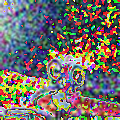

We have the follwing classes ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']
Each class gets an index value {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Chimney': 4, 'Crosswalk': 5, 'Hydrant': 6, 'Motorcycle': 7, 'Other': 8, 'Palm': 9, 'Stair': 10, 'Traffic Light': 11}
For the first image we have index 0


In [7]:
first_elem = train_val_dataset.__getitem__(0)
print(f"An element of a dataset contains {len(first_elem)} fields. (should be 2). The first field is an image, the second value is its corresponding label \n")

# the first index should be a tensor representation of an image
print("tensor of first image", first_elem[0], "\n")

print("image should be of shape 3,size,size: ", first_elem[0].shape)

# convert tensor back to a PIL image and visualize it with display()
display(transforms.ToPILImage()(first_elem[0]))
# Each folder is a class
classes = train_val_dataset.classes
print("We have the follwing classes", classes)

# Each classname is assigned an index
class_names = train_val_dataset.class_to_idx
print("Each class gets an index value", class_names)

# the second index is the numerical value of our label taken from the folder name
print(f"For the first image we have index {first_elem[1]}")

Split this dataset into a training set and a validation set.
For this you can use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)

In this example we will use 20% of the dataset for training and 80% for validation. You should change this percentage to a reasonable value
Remember overfitting and underfitting

In [9]:
train_percentage = 0.9 # how much of the dataset should be used for training

no_train_images = int(train_val_length * train_percentage)
no_valid_images = train_val_length - no_train_images



from sklearn.model_selection import StratifiedShuffleSplit

# Assuming train_val_dataset is your original dataset

# Get labels for each data point
labels = [label for _, label in train_val_dataset]

# Define the stratified splitter
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_percentage, random_state=42)

# Split the data
train_indices, valid_indices = next(stratified_splitter.split(labels, labels))

# Create Subset for training and validation
train_dataset = Subset(train_val_dataset, train_indices)
valid_dataset = Subset(train_val_dataset, valid_indices)

batch_size = 64

# Use SubsetRandomSampler for the DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"We divided the {len(train_val_dataset)} labeled images into {len(train_dataset)} training images and {len(valid_dataset)} validation images using stratified sampling.")



We divided the 3000 labeled images into 2700 training images and 300 validation images using stratified sampling.


Let's Create [Dataloaders](https://pytorch.org/docs/stable/data.html)
Dataloaders loads our data in batches and faster so out training speed increases.

The important arguments of the Dataloader are `dataset, batch_size, shuffle and  num_workers`
We are already giving the argument for dataset, you should choose fitting values for the other arguments

Lets visualize images from the train loader

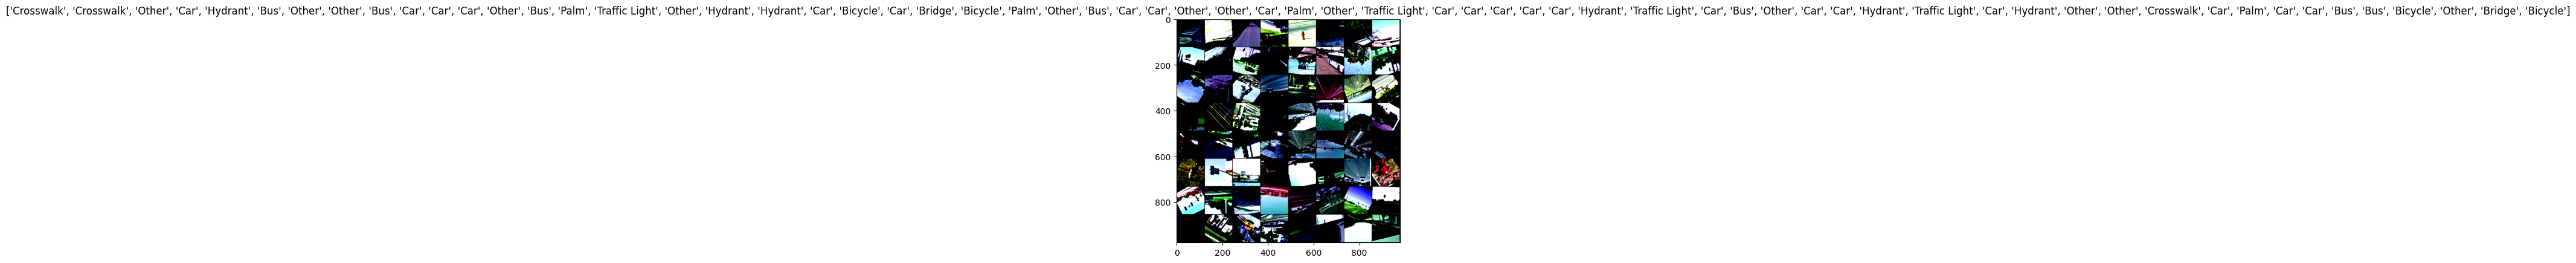

In [10]:
def vis_batch(loader):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1,2,0))
        plt.title(label)

    for batch_inputs, labels in loader:
        grid = torchvision.utils.make_grid(batch_inputs)
        show(grid, label=[classes[int(labels[x])] for x in range(len(labels))])
        break
vis_batch(train_loader)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("RUNNING ON ", device) # should be cuda


class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction=self.reduction)
        return ce_loss



# Load the pretrained ResNet Model
model = models.resnet101(weights=True).to(device)

def get_model_and_optimizer(l1_lambda=0.00001, l2_lambda=0.00001):
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last few layers of the convolutional base
    unfreeze_layers = 70  # Adjust the number of layers to unfreeze as needed
    for param in model.layer4[-unfreeze_layers:].parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Linear(2048,1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512,12),
    ).to(device)

    # Define the optimizer and scheduler
    optimizer = torch.optim.AdamW(
        [
            {'params': model.layer4[-unfreeze_layers:].parameters(), 'lr': 0.0001, 'weight_decay': l2_lambda, 'momentum': 0.9},  # Adjust the learning rate
            {'params': model.fc.parameters(), 'lr': 0.0001,'weight_decay':l2_lambda, 'momentum': 0.9},  # Adjust the learning rate
        ] )


    if l1_lambda > 0:
        l1_reg = torch.tensor(0., device=device)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l1_reg += torch.norm(param, 1)
        optimizer.param_groups[0]['weight_decay'] += l1_lambda * l1_reg.item()
        optimizer.param_groups[1]['weight_decay'] += l1_lambda * l1_reg.item()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)


    return model, optimizer, scheduler



def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.fc.apply(weights_init)

def train_model_with_early_stopping(model, optimizer, patience=5, num_epochs=50):
    start = time.time()
    weights = torch.tensor([200/3000, 136/3000, 309/3000, 910/3000, 32/3000, 317/3000, 243/3000, 21/3000, 343/3000, 233/3000, 54/3000, 202/3000])
    class_weights = weights.to(device)


    criterion = WeightedCrossEntropyLoss(weight=class_weights, reduction='mean')

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            model.train()

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted_class = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted_class == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        print(f"Training epoch loss is = {epoch_loss}, Training accuracy is {int(epoch_acc * 100)}%")

        # Validation
        val_loss = validation_loss(model, valid_loader, criterion)
        scheduler.step(val_loss)


        print(f"Validation Loss: {val_loss}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping. No improvement for {} epochs.".format(patience))
                break

    print(f"This took {round(time.time() - start)} seconds")
    return model

def validation_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
      running_corrects = 0 # used for accuracy calculation
      for inputs, labels in loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          total_loss += loss.item() * inputs.size(0)
          _, predicted_class = torch.max(outputs, 1) # _ = the highest prediction, --> predicted_class, which index hat the highest predicition
          running_corrects += torch.sum(predicted_class == labels)


      print(f"Validation accuracy: {running_corrects / len(loader.dataset) * 100}%")

    return total_loss / len(loader.dataset)

# Train the model with early stopping
pretr_model, optimizer, scheduler = get_model_and_optimizer()
pretr_model = train_model_with_early_stopping(pretr_model, optimizer, patience=30, num_epochs=100)

RUNNING ON  cuda:0
Epoch 1/100
----------
Training epoch loss is = 1.7841986197012443, Training accuracy is 34%
Validation accuracy: 49.333335876464844%
Validation Loss: 1.3285190184911093
Epoch 2/100
----------
Training epoch loss is = 0.9912921368634259, Training accuracy is 54%
Validation accuracy: 58.000003814697266%
Validation Loss: 0.870496145884196
Epoch 3/100
----------
Training epoch loss is = 0.8116310995596426, Training accuracy is 61%
Validation accuracy: 63.33333206176758%
Validation Loss: 0.8847864325841268
Epoch 4/100
----------
Training epoch loss is = 0.7076831619827836, Training accuracy is 64%
Validation accuracy: 68.66666412353516%
Validation Loss: 0.7184994800885518
Epoch 5/100
----------
Training epoch loss is = 0.6400362035963271, Training accuracy is 68%
Validation accuracy: 68.66666412353516%
Validation Loss: 0.6581569043795268
Epoch 6/100
----------
Training epoch loss is = 0.6035283039234303, Training accuracy is 69%
Validation accuracy: 66.66667175292969%
Va

Exemplary output of our model for a batch of images

In [13]:
batch = next(iter(train_loader))

pretr_model = pretr_model.to(device)  # Move the model to the same device as your data

# Assuming 'batch' is a tuple (inputs, labels)
inputs, labels = batch
inputs = inputs.to(device)  # Move the input tensor to the same device as your model

# Make the prediction
prediction = pretr_model(inputs)

# Print the unnormalized prediction
print("unnormalized prediction: \n", prediction)

# Apply softmax to get normalized prediction
softmax = torch.nn.Softmax(dim=1)
normalized_prediction = softmax(prediction)
print("normalized prediction: \n", normalized_prediction)

unnormalized prediction: 
 tensor([[-2.0215, -0.0937, -2.0956, -0.0766, -2.1235, -1.6976, -2.1776, -2.5484,
          5.0094, -1.7868, -1.4266, -2.0960],
        [-1.6908,  2.7704, -0.5061, -0.0704, -1.5792, -0.7516, -1.6064, -1.9333,
         -0.3405, -1.2419, -1.0889, -0.7096],
        [-2.0860,  4.1834, -0.9246,  0.5498, -2.1013, -1.3876, -2.2443, -2.6241,
         -0.5424, -2.1720, -1.6440, -1.5305],
        [-2.0662, -1.3663, -0.8005,  5.2588, -2.2638, -2.0033, -2.7240, -2.3440,
         -1.3656, -1.8538, -2.3436, -1.6035],
        [-1.7331, -1.6477, -0.6263,  5.4647, -2.2986, -1.8822, -2.9468, -2.4717,
         -0.7738, -1.5031, -2.4552, -1.2895],
        [-1.9905, -0.2136, -1.3928,  4.8460, -2.2770, -2.0670, -2.7393, -2.5275,
         -0.1953, -1.9560, -2.4074, -2.0642],
        [-1.3398, -0.2987,  0.0201, -0.2916, -1.3734, -1.3848, -0.7795, -1.5735,
          2.5161, -1.2902, -0.7035, -1.1131],
        [-2.1387, -2.4340, -1.3295,  6.0179, -2.4365, -1.6211, -3.0304, -2.6705,
   

The following method should not be changed. It predicts the classes for each image in the test dataset and stores them in a .csv file.


In [14]:
def create_result_file(model, test_dataset, classes): # DO NOT CHANGE THIS METHOD
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(f"Am I on GPU (cuda:0) or cpu? --> {device}")
    keys = ["ImageName", *classes]

    prediction_dict = {key: [] for key in keys}
    names = test_dataset.imgs
    model.to(device)
    model.eval() # set model to evaluation mode.
    for i in tqdm(range(len(test_dataset))):
        input = test_dataset.__getitem__(i)
        input = input[0].to(device).unsqueeze(0) # take image tensor and add batch dimension
        with torch.no_grad(): # don't calculate gradients
            outputs = model(input).cpu().squeeze().numpy() # get prediction for input image
            prediction_dict["ImageName"].append(os.path.basename(names[i][0])) # save image name
            for class_idx, class_name in enumerate(classes): # save prediction for each class
                prediction_dict[class_name].append(outputs[class_idx])

    df = pd.DataFrame.from_dict(prediction_dict) # convert list into pandas dataframe
    df.to_csv("result.csv", index=False) # save dataframe as .csv

After training we can execute the
`
create_result_file(model, test_dataset, classes) method
`
In this given code we skip training and use our untrained model


In [15]:
create_result_file(pretr_model, test_dataset, classes)

Am I on GPU (cuda:0) or cpu? --> cuda:0


100%|██████████| 8730/8730 [36:02<00:00,  4.04it/s]


If you use Google colab, press the button `update/aktualisieren`
<div>
<img src=https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/UpdateColab.jpg width="300">
<div>
You should see that the file result.csv was created. You can now download this file and upload it at

https://kit-ml1.streamlitapp.com/
